In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, Precision, Recall, TopKCategoricalAccuracy
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

2024-11-12 22:27:32.383545: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 22:27:32.403362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731468452.423869  316790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731468452.430210  316790 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 22:27:32.451533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU')) 

TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:8', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:9', device_type='GPU')]


In [2]:
current_path = os.getcwd()
train_dir = current_path + '/ISIC2019Dataset/data/train/'
val_dir = current_path + '/ISIC2019Dataset/data/val/'
test_dir = current_path + '/ISIC2019Dataset/ISIC_2019_test_dir/'
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

In [4]:
training_metadata_table

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


LABELS

- MEL - Melanoma
- NV - Melanocytic nevus
- BCC - Basal cell carcinoma
- AK - Actinic keratosis
- BKL - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF - Dermatofibroma
- VASC - Vascular lesion
- SCC - Squamous cell carcinoma
- UNK - None of the above

In [5]:
training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)
training_metadata_table.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
training_metadata_table.isnull().sum()

/tmp/ipykernel_578281/174194398.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)


image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64

In [6]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)
ground_truth_table.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [8]:

# for c in classes:
#     # folders inside train_dir
#     class_train_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_train_dir):
#         os.mkdir(class_train_dir)

#     # folders inside val_dir
#     class_val_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_val_dir):
#         os.mkdir(class_val_dir)

In [9]:
# ground_truth_table.set_index('image', inplace=True)
# folder = os.listdir(current_path + training_directory_path)
# image_list = list(ground_truth_table.index)

# for image in image_list:
    
#     fname = image + '.jpg'
#     label = ground_truth_table.loc[image,'label']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(data_dir, label, fname)
#         shutil.copyfile(src, dst)

In [10]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define dataset paths
# data_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/ISIC_2019_data_dir'
# base_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/data'
# train_dir = os.path.join(base_dir, 'train')
# val_dir = os.path.join(base_dir, 'val')

# # Print paths for confirmation
# print("Base directory for split data:", base_dir)
# print("Original data directory:", data_dir)

# # Create directories for training and validation
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Get all classes (folders) in the original dataset directory
# classes = os.listdir(data_dir)

# # Split the data and organize into folders
# for class_name in classes:
#     # Create class-specific directories in train and validation folders
#     os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#     os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    
#     # List all images in each class folder
#     images = os.listdir(os.path.join(data_dir, class_name))
#     images = [os.path.join(data_dir, class_name, img) for img in images]
    
#     # Split images into train and validation sets (e.g., 85% train, 15% validation)
#     train_images, val_images = train_test_split(images, test_size=0.15, random_state=42)
    
#     # Move images to the train directory
#     for img in train_images:
#         shutil.copy(img, os.path.join(train_dir, class_name))
    
#     # Move images to the validation directory
#     for img in val_images:
#         shutil.copy(img, os.path.join(val_dir, class_name))

# print("Data split into training and validation directories successfully.")


## Train Test Split & Data Augmentation

In [3]:
target_size = (224,224)
image_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_batches = image_gen.flow_from_directory(train_dir,
                                              target_size=target_size,
                                              color_mode='rgb',
                                              batch_size=32,
                                              class_mode='categorical')

val_batches = image_gen.flow_from_directory(val_dir,
                                            target_size=target_size,
                                            color_mode='rgb',
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

print(train_batches.class_indices)

Found 21527 images belonging to 8 classes.
Found 3804 images belonging to 8 classes.
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


## Transfer Learning using ResNet50 Model

In [23]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:  
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,115,336 (91.99 MB)

 Trainable params: 17,477,640 (66.67 MB)

 Non-trainable params: 6,637,696 (25.32 MB)

### Calculate Class Weights

In [32]:
label_to_index = train_batches.class_indices  

index_to_label = {v: k for k, v in label_to_index.items()}
ground_truth_table['label_index'] = ground_truth_table['label'].map(label_to_index)

classes = np.unique(ground_truth_table['label_index'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=ground_truth_table['label_index']
)

class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 3.652104959630911,
 1: 0.9528663857959675,
 2: 1.2066977896341464,
 3: 13.248430962343097,
 4: 0.7002156125608138,
 5: 0.24593203883495146,
 6: 5.041998407643312,
 7: 12.515316205533598}

### Training Model 

In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

# Function to compute sample weights
def compute_sample_weights(labels, class_weights):
    sample_weights = np.array([class_weights[np.argmax(label)] for label in labels])
    return sample_weights

def generator_with_sample_weights(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = compute_sample_weights(y, class_weights)
        yield x, y, sample_weights


train_batches_with_weights = generator_with_sample_weights(train_batches, class_weights_dict)
valid_batches_with_weights = generator_with_sample_weights(val_batches, class_weights_dict)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, 
                       Precision(name='precision'), 
                       Recall(name='recall'), 
                       TopKCategoricalAccuracy(k=3, name='top_3_accuracy')])

checkpoint = ModelCheckpoint('resnet50_checkpoint.keras', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='max', min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(
    train_batches_with_weights,
    validation_data=valid_batches_with_weights,
    steps_per_epoch=len(train_batches),
    validation_steps=len(val_batches),
    epochs=15,
    callbacks=callbacks_list
)

# Save the final model
model.save('resnet50_full_model_after_training.keras')

Epoch 1/15
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - categorical_accuracy: 0.7188 - loss: 2.3483 - precision: 0.8005 - recall: 0.6435 - top_3_accuracy: 0.9248
Epoch 1: val_categorical_accuracy improved from -inf to 0.66930, saving model to resnet50_checkpoint.keras
673/673 ━━━━━━━━━━━━━━━━━━━━ 505s 717ms/step - categorical_accuracy: 0.7188 - loss: 2.3478 - precision: 0.8005 - recall: 0.6435 - top_3_accuracy: 0.9248 - val_categorical_accuracy: 0.6693 - val_loss: 1.7139 - val_precision: 0.7433 - val_recall: 0.5839 - val_top_3_accuracy: 0.9324 - learning_rate: 1.0000e-04
Epoch 2/15
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - categorical_accuracy: 0.6974 - loss: 1.5624 - precision: 0.7720 - recall: 0.6147 - top_3_accuracy: 0.9311
Epoch 2: val_categorical_accuracy improved from 0.66930 to 0.69532, saving model to resnet50_checkpoint.keras
673/673 ━━━━━━━━━━━━━━━━━━━━ 468s 696ms/step - categorical_accuracy: 0.6974 - loss: 1.5624 - precision: 0.7720 - recall: 0.6147 - top_3_accuracy: 0.93

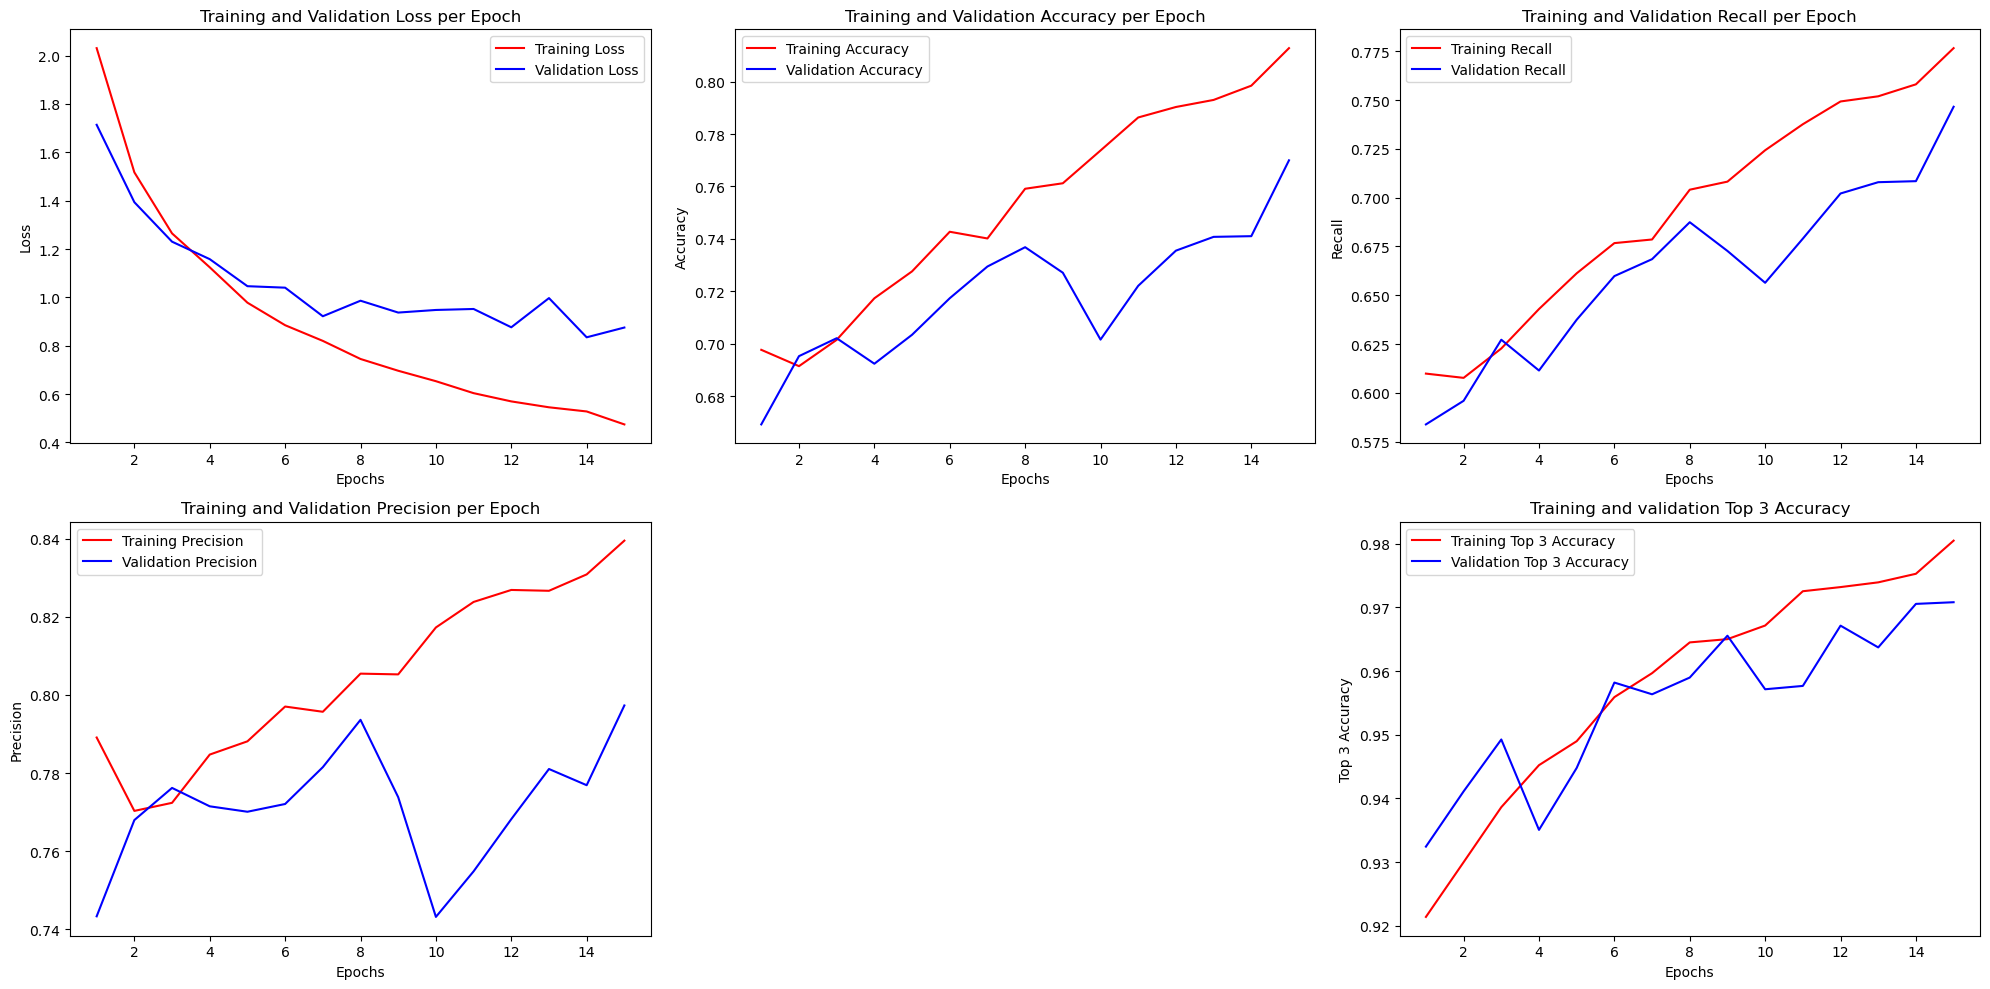

In [34]:
# Extract metrics from history for Resnet50
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
# train_f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'resnet50_training_validation_loss.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'resnet50_training_validation_accuracy.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'resnet50_training_validation_recall.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'resnet50_training_validation_precision.png'))

# Plot F1 Score
# plt.subplot(2, 3, 5)
# plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
# plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
# plt.title('Training and Validation F1 Score per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.savefig(os.path.join(current_path, 'resnet50_training_validation_f1_score.png'))

# Plot Top 3 Accuracy
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top3_acc, 'r-', label='Training Top 3 Accuracy')
plt.plot(epochs, val_top3_acc, 'b-', label='Validation Top 3 Accuracy')
plt.title('Training and validation Top 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 3 Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'resnet50_training_validation_top3_acc.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'resnet50_all_metrics_plots.png'))
plt.show()


In [21]:
for key, value in history.history.items():
    print(f"{key}: {len(value)}")


categorical_accuracy: 15
loss: 15
precision: 15
recall: 15
top_3_accuracy: 15
val_categorical_accuracy: 8
val_loss: 8
val_precision: 8
val_recall: 8
val_top_3_accuracy: 8
learning_rate: 15


In [35]:
model.evaluate(val_batches)

119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 599ms/step - categorical_accuracy: 0.7397 - loss: 0.8538 - precision: 0.7705 - recall: 0.6988 - top_3_accuracy: 0.9667


[0.7497164011001587,
 0.7723448872566223,
 0.8011379837989807,
 0.7402734160423279,
 0.9692429304122925]

In [36]:
predictions = model.predict(val_batches, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = val_batches.classes

119/119 ━━━━━━━━━━━━━━━━━━━━ 76s 613ms/step


In [6]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)
print(classification_report(val_batches.classes, predictions, zero_division=0))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

W0000 00:00:1731468653.648579  316790 gpu_device.cc:2277] Unable to enable peer access between device ordinals 0 and 9, status: INTERNAL: failed to enable peer access from 0x560ddc3f0c20 to 0x560de16e1c70: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731468653.652160  316790 gpu_device.cc:2277] Unable to enable peer access between device ordinals 1 and 9, status: INTERNAL: failed to enable peer access from 0x560ddcd340d0 to 0x560de16e1c70: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731468653.655164  316790 gpu_device.cc:2277] Unable to enable peer access between device ordinals 2 and 9, status: INTERNAL: failed to enable peer access from 0x560ddd6491d0 to 0x560de16e1c70: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731468653.657197  316790 gpu_device.cc:2277] Unable to enable peer access between device ordinals 3 and 9, status: IN

  1/119 ━━━━━━━━━━━━━━━━━━━━ 12:01 6s/step

I0000 00:00:1731468667.013113  318919 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step

2024-11-12 22:32:18.839500: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[28,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-12 22:32:19.165099: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[28,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 628ms/step
Confusion Matrix:
[[  82   18   14    0    3    1   13    0]
 [  25  377   25    5   19   20   22    6]
 [  20   15  267    4   33   42   11    2]
 [   2    1    0   31    0    1    1    0]
 [  14   14   42    4  485  108    7    5]
 [  10   41   92   12  151 1597   14   15]
 [   6   11    5    1    5    1   66    0]
 [   0    1    0    1    1    1    0   34]]


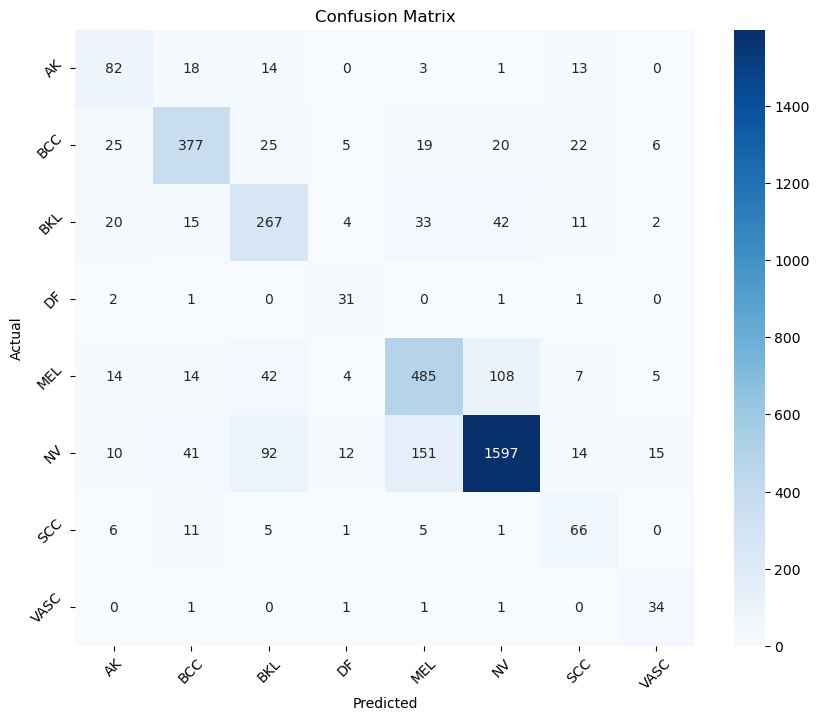

Classification Report:
              precision    recall  f1-score   support

          AK       0.52      0.63      0.57       131
         BCC       0.79      0.76      0.77       499
         BKL       0.60      0.68      0.64       394
          DF       0.53      0.86      0.66        36
         MEL       0.70      0.71      0.70       679
          NV       0.90      0.83      0.86      1932
         SCC       0.49      0.69      0.58        95
        VASC       0.55      0.89      0.68        38

    accuracy                           0.77      3804
   macro avg       0.63      0.76      0.68      3804
weighted avg       0.79      0.77      0.78      3804



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# 1. Load the Best Model
best_model = load_model('resnet50_full_model_after_training.keras')

# 2. Predict on Validation Data
val_steps = len(val_batches)
predictions = best_model.predict(val_batches, steps=len(val_batches), verbose=1)
y_pred = np.argmax(predictions, axis=1)

# 3. Retrieve True Labels
y_true = val_batches.classes

# 4. Map Class Indices to Class Names
class_labels = list(val_batches.class_indices.keys())

# 5. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 6. Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# 7. Generate Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)


Confusion matrix, without normalization
[[  82   18   14    0    3    1   13    0]
 [  25  377   25    5   19   20   22    6]
 [  20   15  267    4   33   42   11    2]
 [   2    1    0   31    0    1    1    0]
 [  14   14   42    4  485  108    7    5]
 [  10   41   92   12  151 1597   14   15]
 [   6   11    5    1    5    1   66    0]
 [   0    1    0    1    1    1    0   34]]


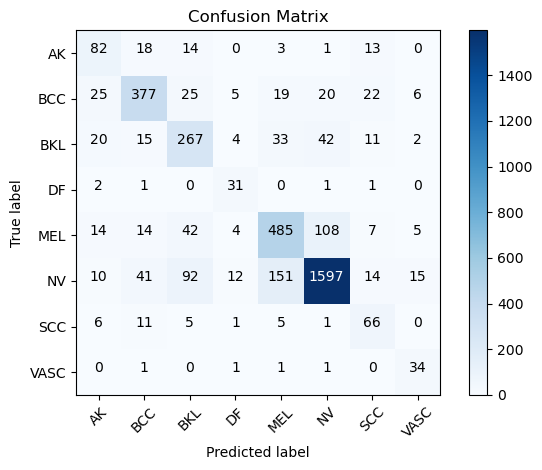

In [5]:
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

test_labels = val_batches.classes
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')